# Load libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import seaborn
import math
import os
import json
from IPython.display import Javascript

# Configurations & Constants

In [8]:
user = 'participant1' # participant1-10
target_freq_as_int = 15 # 15|1
target_freq_unit1 = 'min' # min|s
target_freq_unit2 = 'm' # m|s
dataset_type = '' # '' | time_series_

In [9]:
# participant information
participant_dictionary = json.load(open(f'./data/participant_dictionary.json'))

target_freq = f'{target_freq_as_int}{target_freq_unit1}'
target_freq2 = f'{target_freq_as_int}{target_freq_unit2}'

user_id = participant_dictionary[user]['fonlog_id']
start_date = participant_dictionary[user]['start_date']
end_date_plus_one = participant_dictionary[user]['end_date_plus_one']
end_date_plus_two = participant_dictionary[user]['end_date_plus_two']

color = {
    "boxes": "Blue",
    "whiskers": "Black",
    "medians": "Red",
    "caps": "Gray"
}

wo_columns = {
    "Timestamp": "timestamp",
    "Heart Rate (in Beats per minute)": "heart_rate",
    "Stress Score": "stress_score",
    "Stress Interpretation": "stress_level",
    "Number of Steps": "steps",
    "Wearing Off": "wearing_off",
    "started_at": "wo_start",
    "finished_at": "wo_end",
    "Tremors": "wo_tremors",
    "Slowing down of movement": "wo_slowdown",
    "Change in mood or depression": "wo_moodchange",
    "Rigidity of muscles": "wo_rigidity",
    "Sharp pain or prolonged dull pain": "wo_pain",
    "Impairment of complex movements of the hand and fingers": "wo_impairment_hands",
    "Difficulty integrating thoughts or slowing down of thought": "wo_slow_thoughts",
    "Anxiety or panic attacks": "wo_anxiety",
    "Muscle spasm": "wo_muscle_spasm",
    "activity_target.activity_id": "report_id"
}

drug_intake_columns = {
    "started_at": "drug_intake_start",
    "finished_at": "drug_intake_end",
    "Sharp pain or prolonged dull pain": "drug_intake_tremors",
    "Tremors": "drug_intake_slowdown",
    "Anxiety or panic attacks": "drug_intake_moodchange",
    "Rigidity of muscles": "drug_intake_rigidity",
    "Slowing down of movement": "drug_intake_pain",
    "Difficulty integrating thoughts or slowing down of thought": "drug_intake_impairment_hands",
    "Impairment of complex movements of the hand and fingers": "drug_intake_slow_thoughts",
    "Change in mood or depression": "drug_intake_anxiety",
    "Muscle spasm": "drug_intake_muscle_spasm"
}

symptoms_dictionary = {
    "ふるえる": "Tremors",
    "動作が遅くなる": "Slowing down of movement",
    "気分が変化する または おちこむ": "Change in mood or depression",
    "体のどこかがこわばる": "Rigidity of muscles",
    "するどい痛み または 長ぐ続ぐこぶい痛みがある": "Sharp pain or prolonged dull pain",
    "手先の細かい作業が うまくできない": "Impairment of complex movements of the hand and fingers",
    "思考がまとまらない または 頭の回転がおそい": "Difficulty integrating thoughts or slowing down of thought",
    "不安になる または パニック状態になる": "Anxiety or panic attacks",
    "筋肉がひきつる": "Muscle spasm"
}

# FonLog

## Process wearing-off dataset

In [10]:
activity_type_id = 2 # wearing-off's
# activity_type_id = 12 # wearing-off's

# Load from file
# fonlog_data = pd.read_excel(f'./data/fonlog/records ABC.xlsx',
fonlog_data = pd.read_excel(f'./data/fonlog/records.xlsx',
                           sheet_name='records', engine='openpyxl')
# Make sure to use datetime data type
fonlog_data['activity.started_at'] = pd.to_datetime(fonlog_data['activity.started_at'])
fonlog_data['activity.finished_at'] = pd.to_datetime(fonlog_data['activity.finished_at'])

filtered_fonlog_data = fonlog_data.loc[
    #(fonlog_data['activity_target.customer_id'] == user_id) &
    (fonlog_data['activity_target.user_id'] == user_id) &
    #(fonlog_data['activity_type_group.name'] == 'Wearing-Off for PD') &
    (fonlog_data['activity_type_group.name'] == 'Wearing-off Questionnaire (WOQ)') &
    (fonlog_data['activity.started_at'] >= start_date) &
    (fonlog_data['activity.started_at'] < end_date_plus_two) &
    (fonlog_data['record_type.activity_type_id'] == activity_type_id)
]
#grouped_fonlog_data = filtered_fonlog_data.groupby(['activity_target.activity_id'])
selected_fonlog_data = filtered_fonlog_data[
    ['activity.started_at', 'activity.finished_at', 'activity_target.activity_id']
].to_numpy().astype(str)

# Extract wearing-off periods
#wearing_off_periods = grouped_fonlog_data[
#    ['activity.started_at', 'activity.finished_at']
#].agg(np.unique)
wearing_off_periods = pd.DataFrame(np.unique(selected_fonlog_data, axis=0),
                                   columns=["activity.started_at", "activity.finished_at", "activity_target.activity_id"]
                                   )
wearing_off_periods["activity.started_at"] = pd.to_datetime(wearing_off_periods["activity.started_at"])
wearing_off_periods["activity.finished_at"] = pd.to_datetime(wearing_off_periods["activity.finished_at"])
wearing_off_periods["activity_target.activity_id"] = wearing_off_periods["activity_target.activity_id"].astype(float)
wearing_off_periods = wearing_off_periods.set_index('activity_target.activity_id', drop=False)
#wearing_off_periods['activity_target.activity_id'] = wearing_off_periods.index
wearing_off_periods.rename(
    inplace=True,
    columns={
        "activity.started_at": "started_at",
        "activity.finished_at": "finished_at",
        "activity_target.activity_id": "wearing_off_id" }
)

# # Compute wearing-off duration
# wearing_off_periods['Duration'] = ( (
#     wearing_off_periods['finished_at'] - wearing_off_periods['started_at']
# ) / np.timedelta64(1, "s") ) / 60. # in minutes

# # Show wearing-off summary
# display(wearing_off_periods['Duration'].describe())
# display(wearing_off_periods)

# # Update finished_at when finished_at == started_at
def update_finished_at(row):
    if row["started_at"] == row["finished_at"]:
        return (row["finished_at"] + pd.Timedelta(minutes=15))
    else:
        return (row["finished_at"])

wearing_off_periods['finished_at'] = wearing_off_periods.apply(lambda row: update_finished_at(row), axis=1)

In [11]:
wearing_off_periods

,started_at,finished_at,wearing_off_id
activity_target.activity_id,,,
1018.0,2021-11-25 08:00:00,2021-11-25 08:55:00,1018.0
1022.0,2021-11-25 10:30:00,2021-11-25 11:15:00,1022.0
1029.0,2021-11-25 17:15:00,2021-11-25 18:10:00,1029.0
1033.0,2021-11-25 23:05:00,2021-11-26 01:22:00,1033.0
1043.0,2021-11-26 07:10:00,2021-11-26 08:00:00,1043.0
1044.0,2021-11-26 09:37:00,2021-11-26 10:04:00,1044.0
1051.0,2021-11-26 12:32:00,2021-11-26 13:00:00,1051.0
1052.0,2021-11-26 14:11:00,2021-11-26 14:34:00,1052.0
1058.0,2021-11-26 23:30:00,2021-11-27 00:00:00,1058.0


## Process symptoms dataset

In [12]:
# Pivot table to convert to columns of symptoms
symptoms_wearing_off = filtered_fonlog_data.pivot(
    index='activity_target.activity_id', columns='record_type.name', values='value'
).rename(columns=symptoms_dictionary).drop(columns='共有したい他の症状はありますか？')

In [13]:
# Merge symptoms to wearing-off periods
wearing_off_with_symptoms = pd.merge(
    wearing_off_periods,
    symptoms_wearing_off,
    left_index=True, right_index=True
)
display(wearing_off_with_symptoms)

wearing_off_with_symptoms = wearing_off_with_symptoms.fillna(0).replace({'ある':1, 'ない':0})
# # Show wearing-off symptoms
# display(wearing_off_with_symptoms.describe())
# display(wearing_off_with_symptoms.head())
# display(wearing_off_with_symptoms.tail())

,started_at,finished_at,wearing_off_id,Sharp pain or prolonged dull pain,Tremors,Anxiety or panic attacks,Rigidity of muscles,Slowing down of movement,Difficulty integrating thoughts or slowing down of thought,Impairment of complex movements of the hand and fingers,Change in mood or depression,Muscle spasm
activity_target.activity_id,,,,,,,,,,,,
1018.0,2021-11-25 08:00:00,2021-11-25 08:55:00,1018.0,ある,ある,ない,ある,ある,ない,ある,ない,ある
1022.0,2021-11-25 10:30:00,2021-11-25 11:15:00,1022.0,ない,ある,ない,ある,ある,ない,ある,ない,ない
1029.0,2021-11-25 17:15:00,2021-11-25 18:10:00,1029.0,NaN,ある,NaN,ある,ある,NaN,ある,NaN,NaN
1033.0,2021-11-25 23:05:00,2021-11-26 01:22:00,1033.0,NaN,ある,NaN,ある,ある,NaN,ある,NaN,NaN
1043.0,2021-11-26 07:10:00,2021-11-26 08:00:00,1043.0,NaN,NaN,NaN,ある,NaN,NaN,ある,NaN,NaN
1044.0,2021-11-26 09:37:00,2021-11-26 10:04:00,1044.0,NaN,NaN,NaN,ある,ある,NaN,ある,NaN,NaN
1051.0,2021-11-26 12:32:00,2021-11-26 13:00:00,1051.0,NaN,ある,NaN,ある,ある,NaN,ある,NaN,NaN
1052.0,2021-11-26 14:11:00,2021-11-26 14:34:00,1052.0,NaN,ある,NaN,ある,ある,NaN,ある,NaN,NaN
1058.0,2021-11-26 23:30:00,2021-11-27 00:00:00,1058.0,NaN,ある,NaN,ある,ある,NaN,ある,NaN,NaN


C:\Users\Macky\AppData\Local\Temp\ipykernel_11240\115324914.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wearing_off_with_symptoms = wearing_off_with_symptoms.fillna(0).replace({'ある':1, 'ない':0})


Remove overarching reporting when there are embedded reportings.

11:00 AM      **12:00 PM**        **12:30 PM**     1:00 PM  
    |-------------|----------------|-----------|


In [14]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select distinct
        wearing_off_2.[wearing_off_id] as for_remove_id
    from wearing_off_with_symptoms as wearing_off_1
    join wearing_off_with_symptoms as wearing_off_2
    on (wearing_off_2.[started_at] < wearing_off_1.[finished_at] AND wearing_off_2.[started_at] < wearing_off_1.[started_at]) AND
            (wearing_off_2.[finished_at] > wearing_off_1.[finished_at] AND wearing_off_2.[finished_at] > wearing_off_1.[started_at]) AND
            (wearing_off_1.[wearing_off_id] <> wearing_off_2.[wearing_off_id])
'''
for_remove_ids = pysqldf(cond_join)
# # Show id to remove
# display(for_remove_ids)

wearing_off_with_symptoms = wearing_off_with_symptoms[~wearing_off_with_symptoms['wearing_off_id'].isin(for_remove_ids['for_remove_id'])]

# # Show wearing-off symptoms
# display(wearing_off_with_symptoms.describe())
# display(wearing_off_with_symptoms.head())
# display(wearing_off_with_symptoms.tail())

wearing_off_with_symptoms['finished_at'] = wearing_off_with_symptoms.apply(lambda row: update_finished_at(row), axis=1)

## Process drug intake dataset

In [15]:
activity_type_id = 3 # drug-intake
# activity_type_id = 13 # drug-intake

filtered_fonlog_data = fonlog_data.loc[
    #(fonlog_data['activity_target.customer_id'] == user_id) &
    (fonlog_data['activity_target.user_id'] == user_id) &
    #(fonlog_data['activity_type_group.name'] == 'Wearing-Off for PD') &
    (fonlog_data['activity_type_group.name'] == 'Wearing-off Questionnaire (WOQ)') &
    (fonlog_data['activity.started_at'] >= start_date) &
    (fonlog_data['activity.started_at'] < end_date_plus_two) &
    (fonlog_data['record_type.activity_type_id'] == activity_type_id)
]
#grouped_fonlog_data = filtered_fonlog_data.groupby('activity_target.activity_id')

In [16]:
#drug_intake = grouped_fonlog_data[
#    ['activity.started_at', 'activity.finished_at']
#].agg(np.unique)
drug_intake = pd.DataFrame(np.unique(selected_fonlog_data, axis=0),
                                   columns=["activity.started_at", "activity.finished_at", "activity_target.activity_id"]
                                   )
drug_intake["activity.started_at"] = pd.to_datetime(drug_intake["activity.started_at"])
drug_intake["activity.finished_at"] = pd.to_datetime(drug_intake["activity.finished_at"])
drug_intake["activity_target.activity_id"] = drug_intake["activity_target.activity_id"].astype(float)
drug_intake = drug_intake.set_index('activity_target.activity_id', drop=False)
#drug_intake['activity_target.activity_id'] = drug_intake.index
drug_intake.rename(
    inplace=True,
    columns={
        "activity.started_at": "started_at",
        "activity.finished_at": "finished_at",
        'activity_target.activity_id': 'drug_intake_id'
    }
)
# # Show drug intake summary
# display(drug_intake['drug_intake_id'].describe())
# display(drug_intake.head())

In [17]:
#symptoms_drug_intake = filtered_fonlog_data.pivot(
#    index='activity_target.activity_id', columns='record_type.name', values='value'
#).rename(columns=symptoms_dictionary)
symptoms_drug_intake = symptoms_wearing_off

In [18]:
drug_intake_with_symptoms = pd.merge(
    drug_intake,
    symptoms_drug_intake,
    left_index=True, right_index=True
)

drug_intake_with_symptoms = drug_intake_with_symptoms.fillna(0).replace({'飲めば経くなる':0, '飲んでも変わらない':1, 
                                                                        'ある':1, 'ない':0})
# display(drug_intake_with_symptoms.describe())
# display(drug_intake_with_symptoms.head())
# display(drug_intake_with_symptoms.tail())

C:\Users\Macky\AppData\Local\Temp\ipykernel_11240\4117670447.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  drug_intake_with_symptoms = drug_intake_with_symptoms.fillna(0).replace({'飲めば経くなる':0, '飲んでも変わらない':1,


Remove overarching reporting when there are embedded reportings.

11:00 AM      **12:00 PM**        **12:30 PM**     1:00 PM  
    |-------------|----------------|-----------|

In [19]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select distinct
        drug_intake_2.[activity_target.activity_id] as for_remove_id
    from drug_intake_with_symptoms as drug_intake_1
    join drug_intake_with_symptoms as drug_intake_2
    on (drug_intake_2.[started_at] < drug_intake_1.[finished_at] AND drug_intake_2.[started_at] < drug_intake_1.[started_at]) AND
            (drug_intake_2.[finished_at] > drug_intake_1.[finished_at] AND drug_intake_2.[finished_at] > drug_intake_1.[started_at]) AND
            (drug_intake_1.[drug_intake_id] <> drug_intake_2.[drug_intake_id])
'''
for_remove_ids_in_drug_intake = pysqldf(cond_join)
# display(for_remove_ids_in_drug_intake)

drug_intake_with_symptoms = drug_intake_with_symptoms[~drug_intake_with_symptoms['drug_intake_id'].isin(for_remove_ids_in_drug_intake['for_remove_id'])]
# drug_intake_with_symptoms.describe()

In [20]:
drug_intake_with_symptoms['finished_at'] = drug_intake_with_symptoms.apply(lambda row: update_finished_at(row), axis=1)

In [21]:
if not os.path.exists(f'./data/steps/{user}'):
    os.makedirs(f'./data/steps/{user}')

wearing_off_with_symptoms.to_excel(f'./data/steps/{user}/1-{user}_woq_with_symptoms.xlsx')
drug_intake_with_symptoms.to_excel(f'./data/steps/{user}/2-{user}_drug_intake_with_symptoms.xlsx')

# To save description, for later
# if not os.path.exists(f'./data/summary/{user}'):
#     os.makedirs(f'./data/summary/{user}')

# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter(f'./results/summary/{user}/0-{user}-summary.xlsx', engine='openpyxl')

# # Write each dataframe to a different worksheet.
# drug_intake_with_symptoms.describe().to_excel(writer, sheet_name='Drug Intake Summary')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

# Garmin

## Heart rate

In [22]:
heart_rate = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Heart Rate', index_col='Timestamp',
                           engine='openpyxl')
heart_rate.sort_values('Timestamp', inplace=True)
heart_rate = heart_rate.loc[start_date:end_date_plus_one].rename(
    columns={'Heart Rate (in Beats per minute)': 'heart_rate'}
)
# display(heart_rate.describe())
# display(heart_rate.head())
# display(heart_rate.tail())

## Steps

In [23]:
steps = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Steps', index_col='Timestamp',
                           engine='openpyxl')
steps.sort_values('Timestamp', inplace=True)
steps = steps.loc[start_date:end_date_plus_one].rename(
    columns={'Number of Steps': 'steps'}
)
# display(steps.describe())
# display(steps.head())
# display(steps.tail())

## Stress

In [24]:
stress = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Stress', index_col='Timestamp',
                           engine='openpyxl')
stress.sort_values('Timestamp', inplace=True)
stress = stress.loc[start_date:end_date_plus_one].rename(
    columns={'Stress Score': 'stress_score', 'Stress Interpretation': 'stress_interpretation'}
)
# display(stress.describe())
# display(stress.head())
# display(stress.tail())

## Sleep

In [25]:
sleep = pd.read_excel(f'./data/garmin/{user}.xlsx',
                           sheet_name='Sleep', index_col='Calendar Date',
                           engine='openpyxl')
sleep.sort_values('Start Time', inplace=True)
sleep = sleep.loc[start_date:end_date_plus_one]

# Compute duration in minutes
sleep['Duration'] = (sleep['End Time'] - sleep['Start Time']) / np.timedelta64(1, "m")

# # Show original sleep data format
# display('Original')
# display(sleep.head())
# display(sleep.tail())

# Transform sleep data by sleep classification type
sleep = sleep.pivot_table(
    index = 'Calendar Date',
    columns = 'Sleep Type',
    values = 'Duration',
    aggfunc = 'sum'
)
sleep = pd.DataFrame(sleep.to_records()).set_index('Calendar Date').fillna(0)
# Make sure that sleep index is a DateTimeIndex type
sleep.index = pd.to_datetime(sleep.index)
sleep.index.name = 'Timestamp'

# Compute total non-rem sleep
sleep['nonrem_total'] = (sleep['deep'] + sleep['light'])
sleep['total'] = (sleep['nonrem_total'] + sleep['rem'])
sleep['nonrem_percentage'] = sleep['nonrem_total'] / sleep['total']
sleep['sleep_efficiency'] = sleep['total'] / (sleep['total'] + sleep['awake'])

# Ignore unmeasurable column from sleep dataset
if 'unmeasurable' in sleep.columns:
    sleep.drop(columns=['unmeasurable'], inplace=True)

# # Show transformed sleep data
# display('Summary')
# display(sleep.describe())
# display('Transformed')
# display(sleep)

## Complete collection period before resampling

First, fill missing values according to Garmin's documentation and within the collection period.

### Heart rate
* Fill missing values with -1, as per Garmin's documentation for missing values before resampling
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [26]:
heart_rate_freq = '15s'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = heart_rate_freq, name='Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)

heart_rate = reference.merge(
    heart_rate.resample(heart_rate_freq).mean(), on='Timestamp', how='left'
)#.fillna(-1)

# display(heart_rate.describe())
# display(heart_rate.head())
# display(heart_rate.tail())

### Steps
* Fill missing values with -1 to standardize with other Garmin datasets
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [27]:
# Steps
#     fill missing values with -1 to standardize with other Garmin dataset
#     missing values for the expected period indicates Garmin vivosmart4 was not worn
steps_freq = '15min'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = steps_freq, name='Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)

steps = reference.merge(
    steps.resample(steps_freq).mean(), on='Timestamp', how='left'
)#.fillna(-1)

# display(steps.describe())
# display(steps.head())
# display(steps.tail())

### Stress
* Fill missing values with -1, as per Garmin's documentation for missing values before resampling
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [28]:
stress_freq = '3min'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = stress_freq, name='Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)

stress = reference.merge(
    stress.resample(stress_freq).mean(numeric_only=True), on='Timestamp', how='left'
)#.fillna(-1)

# display(stress.describe())
# display(stress.head())
# display(stress.tail())

### Sleep
* Fill missing values with -1 to standardize with other Garmin datasets
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn

In [29]:
sleep_freq = 'D'
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = sleep_freq, name = 'Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)
sleep = reference.merge(
    sleep.resample(sleep_freq).mean(), on="Timestamp", how='left'
)#.fillna(-1)

# # Show transformed sleep data
# display('Summary')
# display(sleep.describe())
# display('Transformed')
# display(sleep)


In [30]:
# multi_res = pd.concat([heart_rate, steps, stress], axis=1).sort_index(ascending=True)# .to_excel("garmin_multiresolution.xlsx")
# multi_res

# sleep_multi_res = pd.concat([
#     pd.DataFrame(
#         index = pd.date_range(
#             start_date, end_date_plus_two,
#             freq = '15s', name = 'Timestamp'
#         ).drop(
#             pd.Timestamp(end_date_plus_two)
#         )
#     ).merge(
#         sleep.resample('15s').mean(), on='Timestamp', how='left'
#     ).ffill(),

#     pd.DataFrame(
#         index = pd.date_range(
#             start_date, end_date_plus_two,
#             freq = '15min', name = 'Timestamp'
#         ).drop(
#             pd.Timestamp(end_date_plus_two)
#         )
#     ).merge(
#         sleep.resample('15min').mean(), on='Timestamp', how='left'
#     ).ffill(),

#     pd.DataFrame(
#         index = pd.date_range(
#             start_date, end_date_plus_two,
#             freq = '3min', name = 'Timestamp'
#         ).drop(
#             pd.Timestamp(end_date_plus_two)
#         )
#     ).merge(
#         sleep.resample('3min').mean(), on='Timestamp', how='left'
#     ).ffill() 
# ]).reset_index().drop_duplicates(subset=['Timestamp']).set_index('Timestamp').sort_index(ascending=True)
# sleep_multi_res

# multi_res.merge(
#     sleep_multi_res, on='Timestamp', how='left'
# ).sort_index(ascending=True).to_excel("garmin_multiresolution.xlsx")

## Combine Garmin Dataset
Resample according to resampling plan.

Missing values due to resampling:
* Fill using previous known value.
* ``ffill()`` does this step.

In [31]:
# Create reference timestamp dataframe for the collection period
reference = pd.DataFrame(
    index = pd.date_range(
        start_date, end_date_plus_two,
        freq = target_freq, name = 'Timestamp'
    ).drop(
        pd.Timestamp(end_date_plus_two)
    )
)
# display('Reference timestamp')
# display(reference)

# Combine each Garmin dataset to reference timestamp dataframe
garmin_data = reference.merge(
    # downsample heart rate from 15sec to 1min
    #   missing values = -1 same treatment with Garmin with regards to missing value, fitness tracker not worn
    heart_rate.resample(target_freq).mean(), on='Timestamp', how='left'
)#.ffill()
garmin_data = garmin_data.merge(
    steps.resample(target_freq).mean(), on='Timestamp', how='left'
)#.ffill()
garmin_data = garmin_data.merge(
    stress.resample(target_freq).mean(), on='Timestamp', how='left'
)#.ffill()
garmin_data = garmin_data.merge(
    sleep.resample(target_freq).mean().ffill(), on='Timestamp', how='left'
)#.ffill()
# display('Combined Data')
# display(garmin_data)

In [32]:
garmin_data.to_excel(f'./data/steps/{user}/3-{user}_combined_garmin_data_only.xlsx')

# Combine Datasets
Match wearing-off to combined Garmin data based on wearing-off start and end

In [33]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select 
        garmin.*,
        wearing_off_with_symptoms.*,
        case
            when wearing_off_with_symptoms.[started_at] is not null THEN 1
        else 0
        end as 'Wearing Off'
    from garmin_data as garmin
    left join wearing_off_with_symptoms
    on garmin.[Timestamp] BETWEEN wearing_off_with_symptoms.[started_at] AND wearing_off_with_symptoms.[finished_at]
'''

# Change wearing-off columns
combined_data = pysqldf(cond_join).rename(columns=wo_columns)

# Drop duplicates based on timestamp
combined_data = combined_data.drop_duplicates(subset=['timestamp'])

# Set timestamp as index
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data = combined_data.set_index('timestamp')

Compute for wearing-off duration

In [34]:
combined_data['wo_duration'] = ''
combined_data['wo_duration'] = (
    pd.to_datetime(combined_data.index) - pd.to_datetime(combined_data['wo_start'])
) / np.timedelta64(1, target_freq_unit2)

# gid = combined_data['wo_duration'].notnull().cumsum()
# dg = combined_data.groupby(gid)
# base = dg['wo_duration'].transform('last')
# combined_data['wo_duration'] = (  base + ( dg.cumcount() ) * target_freq_as_int)

# display(combined_data.iloc[140:150, ])

Match drug intake to combined Garmin data based on drug intake start and end

In [35]:
pysqldf = lambda q: sqldf(q, globals())
cond_join= '''
    select 
        combined_data.*,
        drug_intake_with_symptoms.*,
        case
            when drug_intake_with_symptoms.[started_at] is not null THEN 1
        else 0
        end as 'drug_intake'
    from combined_data
    left join drug_intake_with_symptoms
    on combined_data.[timestamp] BETWEEN drug_intake_with_symptoms.[started_at] AND drug_intake_with_symptoms.[finished_at]
'''

# Change drug intake columns
combined_data = pysqldf(cond_join).rename(columns={
    "started_at": "drug_intake_start",
    "finished_at": "drug_intake_end",
    "Sharp pain or prolonged dull pain": "drug_intake_tremors",
    "Tremors": "drug_intake_slowdown",
    "Anxiety or panic attacks": "drug_intake_moodchange",
    "Rigidity of muscles": "drug_intake_rigidity",
    "Slowing down of movement": "drug_intake_pain",
    "Difficulty integrating thoughts or slowing down of thought": "drug_intake_impairment_hands",
    "Impairment of complex movements of the hand and fingers": "drug_intake_slow_thoughts",
    "Change in mood or depression": "drug_intake_anxiety",
    "Muscle spasm": "drug_intake_muscle_spasm"
}).drop_duplicates(subset=['timestamp'])

# Drop duplicates based on timestamp
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data = combined_data.set_index('timestamp')
combined_data = combined_data.drop(columns=['activity_target.activity_id'])

Compute time from last drug taken
* find the difference between the reference timestamp and the drug intake start
* convert difference to target frequency's unit e.g. minute, seconds

In [36]:
combined_data['time_from_last_drug_taken'] = ''
combined_data['time_from_last_drug_taken'] = (
    pd.to_datetime(combined_data.index) - pd.to_datetime(combined_data['drug_intake_start'])
) / np.timedelta64(1, target_freq_unit2)

Fill records after a drug intake report by adding target frequency value
* add 1 minute, 15 seconds or 15 minutes to succeeding records after the drug intake end
* reference: https://stackoverflow.com/a/42748625/2303766

In [37]:
gid = combined_data['time_from_last_drug_taken'].notnull().cumsum()
dg = combined_data.groupby(gid)
base = dg['time_from_last_drug_taken'].transform('last')
combined_data['time_from_last_drug_taken'] = (  base + ( dg.cumcount() ) * target_freq_as_int)

if combined_data['time_from_last_drug_taken'].isna().any():
    combined_data['time_from_last_drug_taken'] = combined_data['time_from_last_drug_taken'].fillna(0)

Generate final symptoms i.e., initial symptom + symptom after drug intake

In [38]:
wo_symptoms = ['wo_pain', 'wo_tremors', 'wo_anxiety', 'wo_rigidity',
               'wo_slowdown', 'wo_slow_thoughts', 'wo_impairment_hands', 
               'wo_moodchange', 'wo_muscle_spasm']

drug_intake_symptoms = ['drug_intake_pain', 'drug_intake_tremors',
                        'drug_intake_anxiety', 'drug_intake_rigidity',
                        'drug_intake_slowdown', 'drug_intake_slow_thoughts',
                        'drug_intake_impairment_hands', 
                        'drug_intake_moodchange', 'drug_intake_muscle_spasm']

def generate_final_symptoms(row):
    values = []
    for wo_symptom, drug_intake_symptom in zip(wo_symptoms, drug_intake_symptoms):
        if math.isnan(row[drug_intake_symptom]):
            if row[wo_symptom] is None or math.isnan(row[wo_symptom]):
                values.append(0)
            else:
                values.append(row[wo_symptom])
        else:
            values.append(row[drug_intake_symptom])
    if sum(values) >= 1:
        values.append(1)
    else:
        values.append(0)
    return pd.Series(values)

symptoms = combined_data.apply(lambda row: generate_final_symptoms(row), axis=1)
symptoms.columns = ['pain', 'tremors', 'anxiety', 'rigidity', 'slowdown', 'slow_thoughts',
                    'impairment_hands', 'moodchange', 'muscle_spasm', 'wearing_off_post_meds']
# combined_data = combined_data.drop(columns=['y'])
combined_data = combined_data.join(symptoms)

Compute for final wearing_off based on
* wearing_off: reported from WoQ-9 Part 1 (symptoms)
* wearing_off_post_meds: reported from WoQ-9 Part 2 (Medicine Intake & its effect on the symptoms)

In [39]:
def combine_wearing_offs(n):
    if n > 0:
        return 1
    else:
        return 0

combined_data["wearing_off"] = (combined_data.wearing_off + combined_data.wearing_off_post_meds).apply(
    lambda n: combine_wearing_offs(n)
).values

# Post-Processing

## Include hour & day of the week
Include hour and day of the week

In [40]:
combined_data['timestamp_hour'] = combined_data.index.hour
combined_data['timestamp_dayofweek'] = combined_data.index.dayofweek

## Encode hour-features as cyclical features
Include hour sine & hour cosine

In [41]:
# Fix timestamp format
date_time = pd.to_datetime(combined_data.index, format='%d.%m.%Y %H:%M:%S')

# Convert to timestamp
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Get seconds per day
day = 24 * 60 * 60 
# Get seconds per year
year = 365.2425 * day

# Get sine(), cosine() for hour-feature
combined_data['timestamp_hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
combined_data['timestamp_hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# Move `wearing_off` feature at the end of the dataframe
tmp = combined_data.pop('timestamp_dayofweek')
combined_data['timestamp_dayofweek'] = tmp
tmp = combined_data.pop('wearing_off')
combined_data['wearing_off'] = tmp

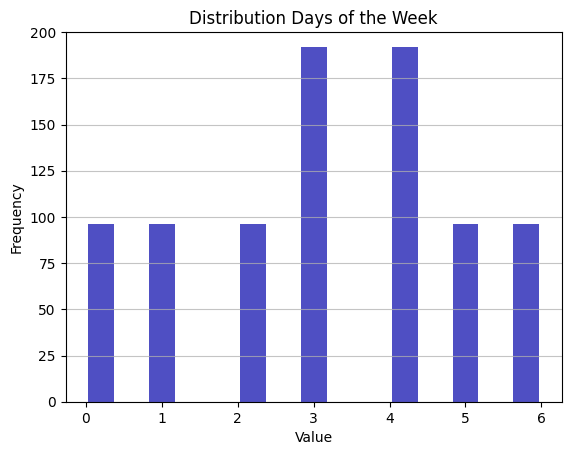

<Figure size 2400x1000 with 0 Axes>

In [42]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=combined_data['timestamp_dayofweek'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Days of the Week')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.figure(figsize=(24, 10))
plt.show()

<Axes: xlabel='timestamp'>

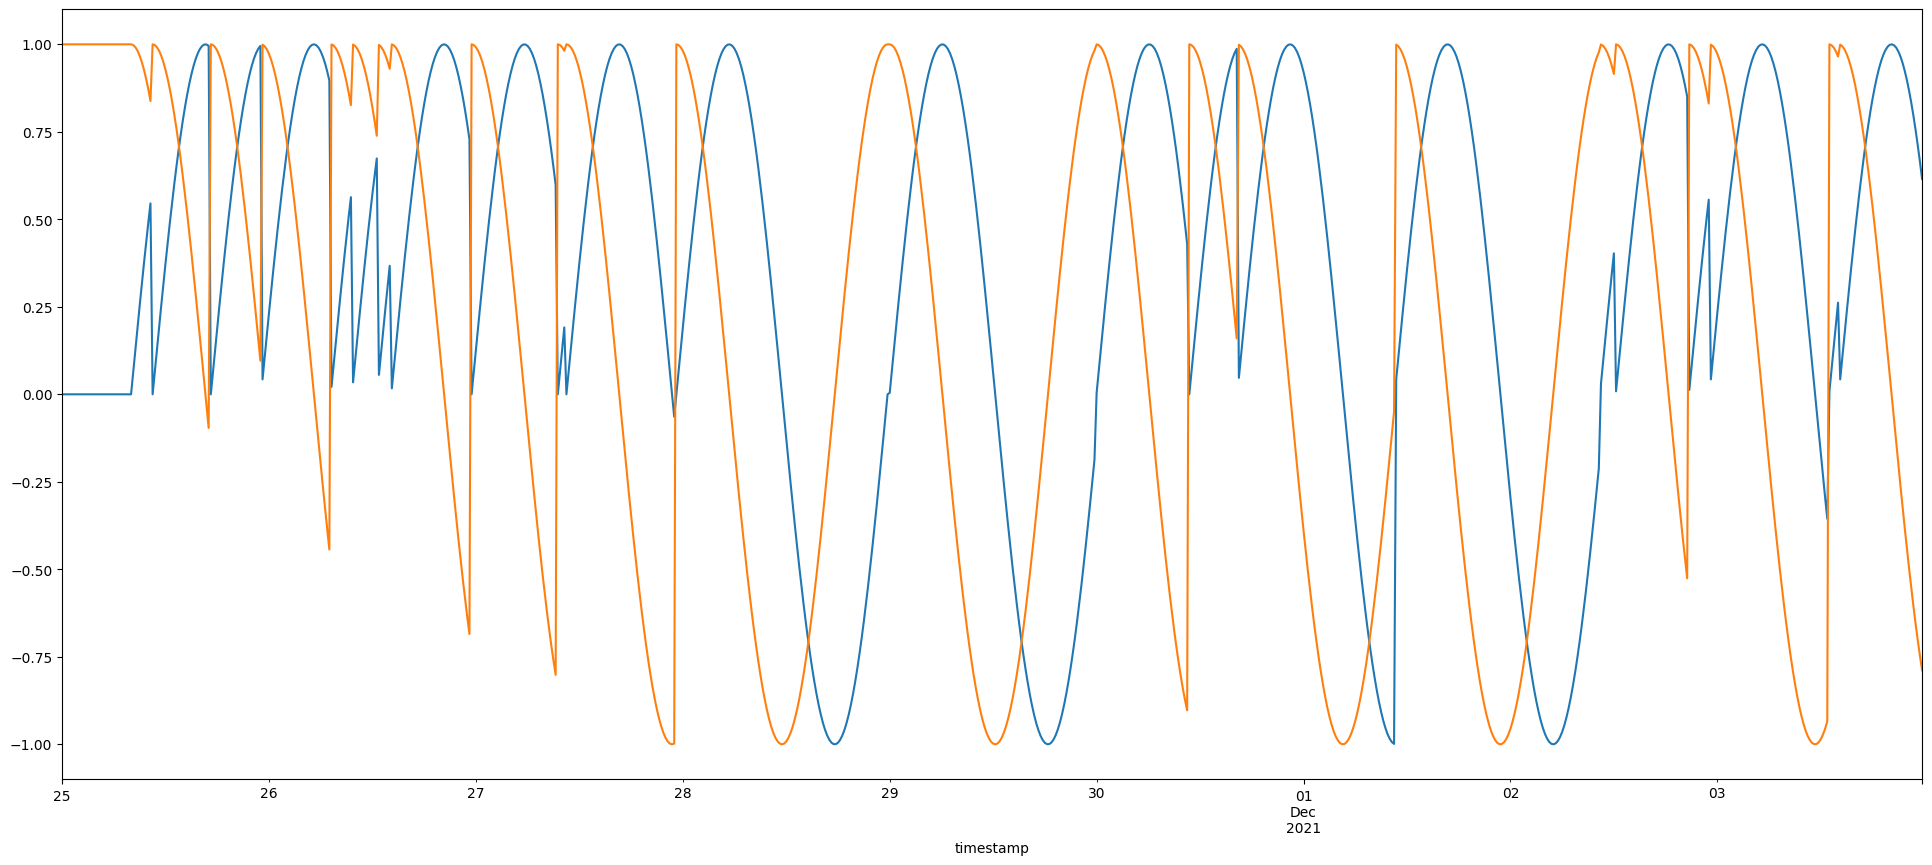

In [43]:
np.sin(combined_data['time_from_last_drug_taken'] * (2 * np.pi / combined_data['time_from_last_drug_taken'].max())).plot(figsize=(24,10))
np.cos(combined_data['time_from_last_drug_taken'] * (2 * np.pi / combined_data['time_from_last_drug_taken'].max())).plot(figsize=(24,10))

In [44]:
combined_data.isna().any()

heart_rate                       True
steps                           False
stress_score                    False
awake                            True
deep                             True
light                            True
rem                              True
nonrem_total                     True
total                            True
nonrem_percentage                True
sleep_efficiency                 True
report_id                        True
wo_start                         True
wo_end                           True
wearing_off_id                   True
wo_pain                          True
wo_tremors                       True
wo_anxiety                       True
wo_rigidity                      True
wo_slowdown                      True
wo_slow_thoughts                 True
wo_impairment_hands              True
wo_moodchange                    True
wo_muscle_spasm                  True
wo_duration                      True
drug_intake_start                True
drug_intake_

In [45]:
combined_data.to_excel(f'./data/4-combined_data_{user}_{target_freq}.xlsx')

In [46]:
display(Javascript("alert('Done')"))

<IPython.core.display.Javascript object>

## Generate shifted data

In [47]:
# Configurations
# columns = [ 'timestamp', 
#            'heart_rate', 'steps', 'stress_score',
#            'awake', 'deep', 'light', 'rem', 'nonrem_total', 'total', 
#            'nonrem_percentage', 'sleep_efficiency']

# # Include FonLog data
# columns = columns + ['time_from_last_drug_taken', 'wo_duration'] \
#                   + ["wearing_off_post_meds", "wearing_off"]
# target_column = "wearing_off"

# interval = "15min"

### Add wearing-off from future to current time
$$
X_t, y_t \rightarrow y_{(t+1 \texttt{hour})}
$$

In [48]:
# # participant_number = 1
# for participant_number in range(1,11):
#     data = pd.read_excel(f"data/original/4-combined_data_participant{participant_number}_{interval}.xlsx",
#                         index_col = "timestamp")

#     data["wearing_off"] = (data.wearing_off + data.wearing_off_post_meds).apply(
#         lambda n: combine_wearing_offs(n)
#     ).values
    
#     # select only columns
#     # data = data.loc[:, columns[1:]]

#     # shift data
#     # 60: target forecast of 1 hour
#     # 15: current frequency
#     forecast_lead = 60
#     forecast_lead_rows = int( 60 / 15 )
#     target = f"{target_column}_lead{forecast_lead}"

#     data[target] = data[target_column].shift(-forecast_lead_rows)
#     data = data.iloc[:-forecast_lead_rows]

#     # Save to Excel
#     data.to_excel(f"data/4-combined_data_participant{participant_number}_{interval}.xlsx")

### Add previous features
$$
X_{t-1}, y_{t-1}, X_{t} \rightarrow y_{t}
$$

In [49]:
# for participant_number in range(1,11):
#     data = pd.read_excel(f"data/original/4-combined_data_participant{participant_number}_{interval}.xlsx",
#                         index_col = "timestamp")

#     data["wearing_off"] = (data.wearing_off + data.wearing_off_post_meds).apply(
#         lambda n: combine_wearing_offs(n)
#     ).values
    
#     # select only columns
#     # data = data.loc[:, columns[1:]]

#     # shift data
#     # 60: target forecast of 1 hour
#     # 15: current frequency
#     forecast_lead = 60
#     forecast_lead_rows = int( 60 / 15 )

#     data = pd.concat([
#         data,                                                         # data at current time step
#         data.shift(forecast_lead_rows).add_suffix("-1") # data at previous time step
#     ], axis=1)

#     # Save to Excel
#     data.to_excel(f"data/4-combined_data_participant{participant_number}_{interval}.xlsx")

## Others

In [50]:
# from openpyxl import load_workbook
# # https://stackoverflow.com/a/47740262/2303766
# def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
#                        truncate_sheet=False, 
#                        **to_excel_kwargs):
#     """
#     Append a DataFrame [df] to existing Excel file [filename]
#     into [sheet_name] Sheet.
#     If [filename] doesn't exist, then this function will create it.

#     @param filename: File path or existing ExcelWriter
#                      (Example: '/path/to/file.xlsx')
#     @param df: DataFrame to save to workbook
#     @param sheet_name: Name of sheet which will contain DataFrame.
#                        (default: 'Sheet1')
#     @param startrow: upper left cell row to dump data frame.
#                      Per default (startrow=None) calculate the last row
#                      in the existing DF and write to the next row...
#     @param truncate_sheet: truncate (remove and recreate) [sheet_name]
#                            before writing DataFrame to Excel file
#     @param to_excel_kwargs: arguments which will be passed to `DataFrame.to_excel()`
#                             [can be a dictionary]
#     @return: None

#     Usage examples:

#     >>> append_df_to_excel('d:/temp/test.xlsx', df)

#     >>> append_df_to_excel('d:/temp/test.xlsx', df, header=None, index=False)

#     >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2',
#                            index=False)

#     >>> append_df_to_excel('d:/temp/test.xlsx', df, sheet_name='Sheet2', 
#                            index=False, startrow=25)

#     (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
#     """
#     # Excel file doesn't exist - saving and exiting
#     if not os.path.isfile(filename):
#         df.to_excel(
#             filename,
#             sheet_name=sheet_name, 
#             startrow=startrow if startrow is not None else 0, 
#             **to_excel_kwargs)
#         return
    
#     # ignore [engine] parameter if it was passed
#     if 'engine' in to_excel_kwargs:
#         to_excel_kwargs.pop('engine')

#     writer = pd.ExcelWriter(filename, engine='openpyxl', mode='a')

#     # try to open an existing workbook
#     writer.book = load_workbook(filename)
    
#     # get the last row in the existing Excel sheet
#     # if it was not specified explicitly
#     if startrow is None and sheet_name in writer.book.sheetnames:
#         startrow = writer.book[sheet_name].max_row

#     # truncate sheet
#     if truncate_sheet and sheet_name in writer.book.sheetnames:
#         # index of [sheet_name] sheet
#         idx = writer.book.sheetnames.index(sheet_name)
#         # remove [sheet_name]
#         writer.book.remove(writer.book.worksheets[idx])
#         # create an empty sheet [sheet_name] using old index
#         writer.book.create_sheet(sheet_name, idx)
    
#     # copy existing sheets
#     writer.sheets = {ws.title:ws for ws in writer.book.worksheets}

#     if startrow is None:
#         startrow = 0

#     # write out the new sheet
#     df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

#     # save the workbook
#     writer.save()

# independent_variables = ['heart_rate', 'steps', 'stress_score',
#     'awake', 'deep', 'light', 'rem', 'nonrem_total',
#     'total', 'nonrem_percentage', 'sleep_efficiency',
#     'time_from_last_drug_taken', 'drug_intake']

# dependent_variables = [ 
#     'wo_pain', 'wo_tremors', 'wo_anxiety', 'wo_rigidity',
#     'wo_slowdown', 'wo_slow_thoughts', 'wo_impairment_hands',
#     'wo_moodchange', 'wo_muscle_spasm',
    
#     'pain', 'tremors', 'anxiety', 'rigidity',
#     'slowdown', 'slow_thoughts', 'impairment_hands',
#     'moodchange', 'muscle_spasm',
#     'wo_duration', 'wearing_off',
#     'wearing_off_post_meds'
# ]

# find_correlation = independent_variables + dependent_variables

# correlation_results = combined_data.fillna(0)[combined_data.columns & find_correlation].corr(method='pearson').loc[
#     independent_variables, dependent_variables
# ]

# append_df_to_excel(f'./results/correlation.xlsx',
#                   correlation_results,
#                   sheet_name=f'{user}_{target_freq}')